In [7]:
import os
os.environ['SCIPY_ARRAY_API'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline


In [8]:
df=pd.read_csv(r'C:\Users\mhuza\Desktop\MINI-Projects-ML\Driectory\creditcard.csv')
# df.isnull().sum()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


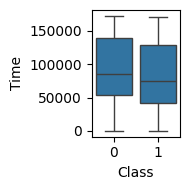

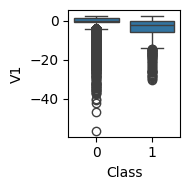

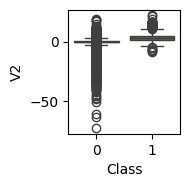

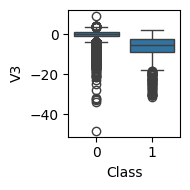

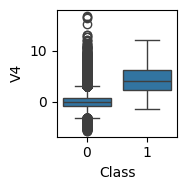

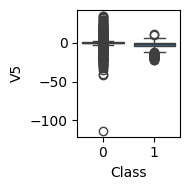

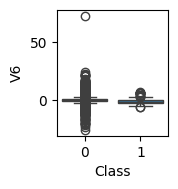

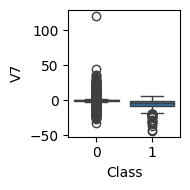

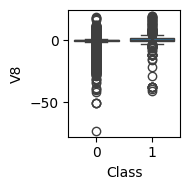

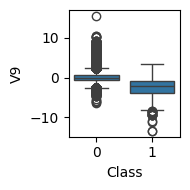

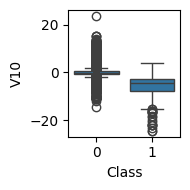

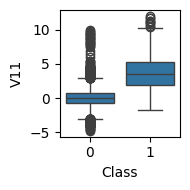

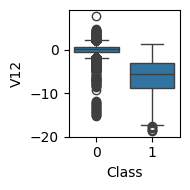

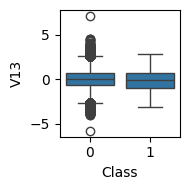

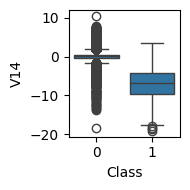

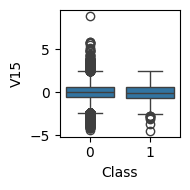

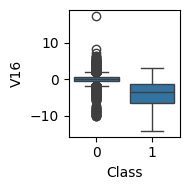

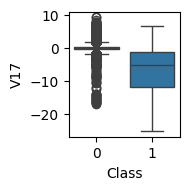

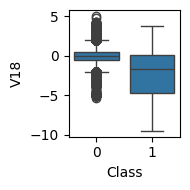

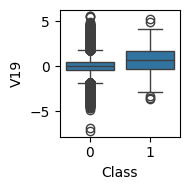

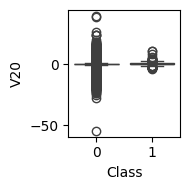

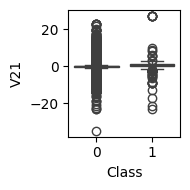

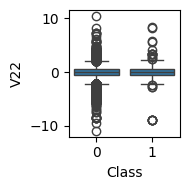

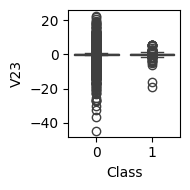

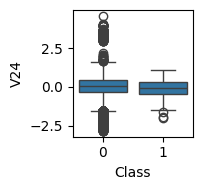

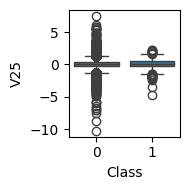

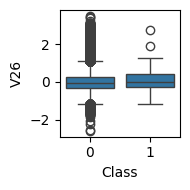

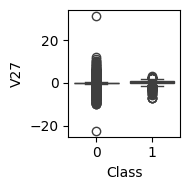

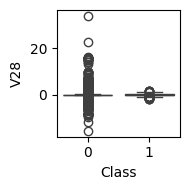

In [9]:
numeric_columns=df.copy()
numeric_columns=numeric_columns.drop('Amount',axis=1)
numeric_columns=numeric_columns.drop('Class',axis=1)

for cols in numeric_columns:
    plt.figure(figsize=(2,2))
    sns.boxplot(x="Class",y=cols,data=df)
    plt.tight_layout()
    plt.show()
# although we see a lot of outliers, we wont cap them considering that they may be frauds

<Axes: xlabel='Class', ylabel='count'>

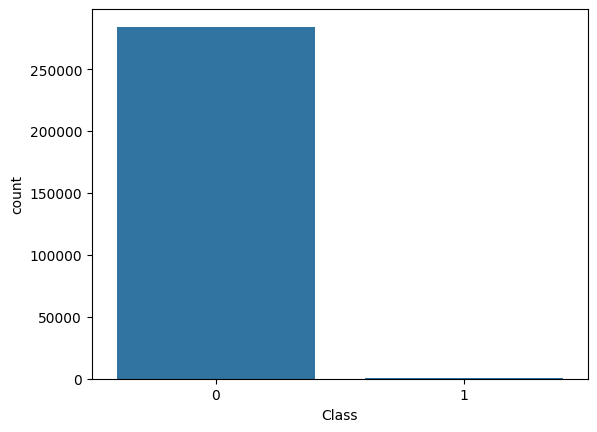

In [10]:
sns.countplot(x='Class',data=df)


In [11]:
# As we can see, the classes are heavily imbalanced, and considering that we have to create a model that should know when a fraud occurs, it should have a 50/50 data set of both classes available in equal ratios
# for that we will use SMOTE-Overcrowd the data so it may be trained well on both scenarios
# ---------------------------------------------Feature Engineering-----------------------------------------------
# first we need to set the features so they may not influence eachother or cause errors in predciting outputs
# 1)Scale Time and Amount-For that we will use Robust scaler--Why? because the dataset, like other fraud detections datasets, contains a lot of outliers. Robust scalar scales the data by median and IQR, so it is not affected by outliers

from sklearn.preprocessing import RobustScaler
robust_scaler=RobustScaler()
time_df=df['Time'].values.reshape(-1,1) #or we can do df[['Time']] because robust scalar works on 2D arrays and we have a 1d array to work on
updated_time=robust_scaler.fit_transform(time_df)
df['Scaled_time']=updated_time
# perhaps, we can do it directly as well
df['Scaled_Amount']=robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df=df.drop(['Time','Amount'],axis=1)
df.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_time,Scaled_Amount
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,1.034951,-0.296653
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,1.034963,0.038986
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,1.034975,0.641096
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,1.034975,-0.167680
284806,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,...,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0,1.035022,2.724796


In [12]:
#------------------------------- THE MOST IMPORTANT THING TO KEEP IN MIND ---------------------------------
# before oversampling or undersampling the dataset, it is necessary that you should Split your data set with equal distibution of each class.
# then oversample the training set and train your model. Then, see the results by testing on the testing set that contains the original data that was not oversampled or changed in anyway
# this helps us to see how well the model performs in real world scenarios

from sklearn.model_selection import train_test_split
# Train test split data randomly divides your data into training and testing data sets
# this means if your data set is highly imbalanced, like ours in this case, the training set might not receive non-fraud cases
# in that scenario, it ruins your model evaluation
# so we make use of StratifiedShuffleSplit that allows equal dividing of both classes in both sets to allow accurate evaluations
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score
X=df.drop('Class',axis='columns')
y=df['Class']

equal_splitting = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
xgb_cv_scores = []
lr_cv_scores = []
for train_index, test_index in equal_splitting.split(X, y):
    # so basically what split does here is divide our dataset into n folds, 5 in our case,
    # this means, in each loop, our test and train datas will contain different datsa compared to other iterations
    # the reason why we are setting a loop and working on different sets is to help choose the most suitable model for our machine learning model
    # each model, XGBoost, random classifier will be tested in this loop and the one with the highest accuracy will be our final model
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #lets check if our data has equal distribution of classes
    print("Train class distribution:")
    print(y_train.value_counts(normalize=True)) 

    print("Test class distribution:")
    print(y_test.value_counts(normalize=True))
    print("-" * 40)
    #it certainly does


    #lets use smote to oversample our data
    lr_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('lr', LogisticRegression(max_iter=1000))
    ])

    lr_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='accuracy')
    lr_cv_scores.append(lr_scores.mean())

    # XGBoost pipeline
    xgb_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', XGBClassifier(random_state=42))
    ])

    xgb_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='accuracy')
    xgb_cv_scores.append(xgb_scores.mean())

# Print average scores from all outer splits
print(f"Logistic Regression CV Accuracy: {np.mean(lr_cv_scores)*100:.2f}% ± {np.std(lr_cv_scores)*100:.2f}%")
print(f"XGBoost CV Accuracy: {np.mean(xgb_cv_scores)*100:.2f}% ± {np.std(xgb_cv_scores)*100:.2f}%")

Train class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test class distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64
----------------------------------------
Train class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test class distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64
----------------------------------------
Train class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test class distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64
----------------------------------------
Logistic Regression CV Accuracy: 97.42% ± 0.13%
XGBoost CV Accuracy: 99.93% ± 0.01%


In [13]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
 
    X_train_2, X_test_2 = X.iloc[train_index], X.iloc[test_index]
    y_train_2, y_test_2 = y.iloc[train_index], y.iloc[test_index]

smote_2 = SMOTE(random_state=42)
resampled_Xtrain_2, resampled_Ytrain_2 = smote_2.fit_resample(X_train_2, y_train_2)

xgbmodel = XGBClassifier(random_state=42)
xgbmodel.fit(resampled_Xtrain_2, resampled_Ytrain_2)
y_pred_xgb = xgbmodel.predict(X_test_2)
print("===== XGBoost Model =====")
print(f"Accuracy: {accuracy_score(y_test_2, y_pred_xgb)*100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test_2, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test_2, y_pred_xgb, digits=4))
print("-" * 60)


===== XGBoost Model =====
Accuracy: 99.92%
Confusion Matrix:
[[56831    33]
 [   14    84]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996     56864
           1     0.7179    0.8571    0.7814        98

    accuracy                         0.9992     56962
   macro avg     0.8589    0.9283    0.8905     56962
weighted avg     0.9993    0.9992    0.9992     56962

------------------------------------------------------------


In [14]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(resampled_Xtrain_2, resampled_Ytrain_2)
y_pred_lr = logistic_model.predict(X_test_2)
print("===== Logistic Regression Model =====")
print(f"Accuracy: {accuracy_score(y_test_2, y_pred_lr)*100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test_2, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test_2, y_pred_lr, digits=4))
print("=" * 60)

===== Logistic Regression Model =====
Accuracy: 97.47%
Confusion Matrix:
[[55431  1433]
 [    8    90]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9748    0.9872     56864
           1     0.0591    0.9184    0.1110        98

    accuracy                         0.9747     56962
   macro avg     0.5295    0.9466    0.5491     56962
weighted avg     0.9982    0.9747    0.9857     56962



In [15]:
xgbmodel_noSmote= XGBClassifier(random_state=42)
xgbmodel_noSmote.fit(X_train, y_train)
y_pred_nosmote = xgbmodel.predict(X_test)
print("===== XGBoost Model =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nosmote)*100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nosmote))
print("Classification Report:")
print(classification_report(y_test, y_pred_nosmote, digits=4))
print("-" * 60)


===== XGBoost Model =====
Accuracy: 99.99%
Confusion Matrix:
[[56857     7]
 [    1    97]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9999    0.9999     56864
           1     0.9327    0.9898    0.9604        98

    accuracy                         0.9999     56962
   macro avg     0.9663    0.9948    0.9802     56962
weighted avg     0.9999    0.9999    0.9999     56962

------------------------------------------------------------


In [16]:
# ------------------------------------------Important Notes-----------------------------------------
# Although the model shows a very high accuracy of 99.95%, this metric can be misleading
#  in the context of highly imbalanced datasets like fraud detection.
#  Since the vast majority of transactions are legitimate, a model that simply predicts "non-fraud" for most cases
#  will achieve high accuracy without actually detecting fraud effectively. Accuracy does not reflect how well 
#  the model identifies the minority class (fraud), which is often the most critical part of the problem. 
# Instead, metrics like precision, recall, and the F1-score give a clearer picture of the model’s true 
# performance by showing how many fraud cases it correctly detects (recall) and how many of its fraud
#  predictions are actually correct (precision). Therefore, relying solely on accuracy may hide poor
#  detection of fraud cases, making it an unreliable indicator of how well the model will perform in 
# real-world fraud detection scenarios.
# When you use SMOTE to oversample the minority class in your training data, the model gets a more balanced view
#  during learning, which usually helps it detect fraud cases better. This can improve recall and precision on 
# the minority class because the model isn’t overwhelmed by the majority class.
# However, SMOTE is applied only on the training data, not the test data. 
# This is crucial — your test set still reflects the real-world imbalance, so your model’s evaluation there is
#  more realistic.

# That said, even if accuracy looks high after using SMOTE, it still might be misleading if you just look at 
# accuracy alone. The real benefit of SMOTE is that it helps improve metrics like recall and F1-score for 
# fraud detection, which accuracy doesn’t fully capture. So, using SMOTE typically leads to better detection of 
# fraud cases without inflating performance metrics on the original imbalanced test set.

In [17]:
# WHY DID XGBoost without SMOTE perform better than the other datasets?
# This can happen if the model is powerful enough to learn the minority class patterns without
#  artificial oversampling.
# Also, SMOTE sometimes adds synthetic noise, which can reduce model generalization.
# With imbalanced data, accuracy can be inflated; focus on recall/precision/F1 for minority class.

